In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/100k-courseras-course-reviews-dataset/reviews.csv
/kaggle/input/100k-courseras-course-reviews-dataset/reviews_by_course.csv


In [2]:
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
import re
from sklearn.feature_extraction.text import CountVectorizer
from wordcloud import WordCloud
import spacy
import nltk
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
import csv
import re 
import string
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

In [4]:
df = pd.read_csv('/kaggle/input/100k-courseras-course-reviews-dataset/reviews.csv')
df.head()

,Id,Review,Label
0,0,good and interesting,5
1,1,"This class is very helpful to me. Currently, I...",5
2,2,like!Prof and TAs are helpful and the discussi...,5
3,3,Easy to follow and includes a lot basic and im...,5
4,4,Really nice teacher!I could got the point eazl...,4


In [5]:
df2 = pd.read_csv('/kaggle/input/100k-courseras-course-reviews-dataset/reviews_by_course.csv')
df2.head()

,CourseId,Review,Label
0,2-speed-it,BOring,1
1,2-speed-it,Bravo !,5
2,2-speed-it,Very goo,5
3,2-speed-it,"Great course - I recommend it for all, especia...",5
4,2-speed-it,One of the most useful course on IT Management!,5


# We will be working on DF

In [6]:
df.isnull().sum()

Id        0
Review    0
Label     0
dtype: int64

In [7]:
label_count = df['Label'].value_counts()
print(label_count)

5    79173
4    18054
3     5071
1     2469
2     2251
Name: Label, dtype: int64


In [8]:
label_values = df['Label'].values
label_values

array([5, 5, 5, ..., 5, 4, 4])

# Data Exploration 

**LABEL DISTRIBUTION**

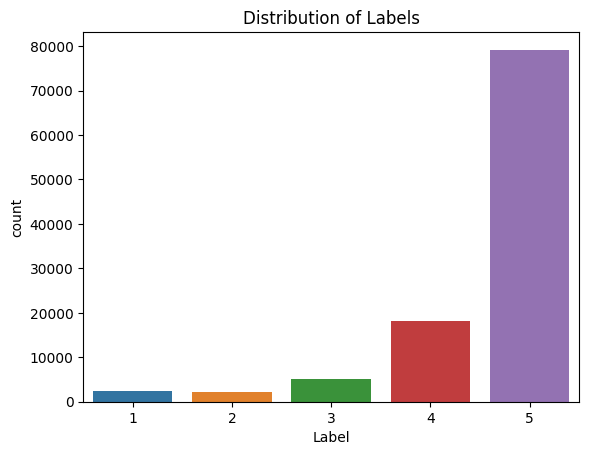

In [9]:
sns.countplot(x='Label',data=df)
plt.title('Distribution of Labels')
plt.show()

In [10]:
df.shape

(107018, 3)

**There are Total 107018 Reviews**

# Length of the Text 

In [11]:
df['text_length'] = df['Review'].apply(len)

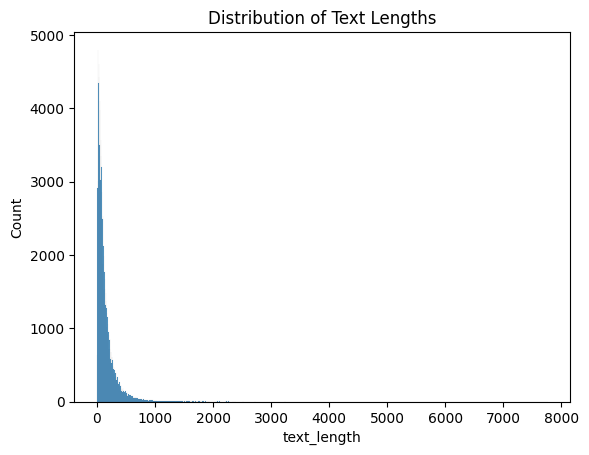

In [12]:
sns.histplot(x='text_length', data=df)
plt.title('Distribution of Text Lengths')
plt.show()

# Extract and seperate the data based on labels

In [13]:
train0=df[df['Label']==0]
train1=df[df['Label']==1]
train2=df[df['Label']==2]
train3=df[df['Label']==3]
train4=df[df['Label']==4]
train5=df[df['Label']==5]

# Peeking at the Distribution between each label

In [14]:
train0.shape, train1.shape, train2.shape, train3.shape, train4.shape, train5.shape

((0, 4), (2469, 4), (2251, 4), (5071, 4), (18054, 4), (79173, 4))

# Reducing the data of each label by 10

In [15]:
train0=train0[:int(train0.shape[0]/10)]
train1=train1[:int(train1.shape[0]/10)]
train2=train2[:int(train2.shape[0]/10)]
train3=train3[:int(train3.shape[0]/10)]
train4=train4[:int(train4.shape[0]/10)]
train5=train5[:int(train5.shape[0]/10)]

In [16]:
train0.shape, train1.shape, train2.shape, train3.shape, train4.shape, train5.shape

((0, 4), (246, 4), (225, 4), (507, 4), (1805, 4), (7917, 4))

In [17]:
df=pd.concat([train0,train1,train2,train3,train4,train5],axis=0)

In [18]:
df.shape

(10700, 4)

# Check for NULL

In [19]:
total_null = df.isnull().sum().sort_values(ascending = False)
percent = ((df.isnull().sum()/df.isnull().count())*100).sort_values(ascending = False)
print("Total records = ", df.shape[0])

missing_data = pd.concat([total_null,percent.round(2)],axis=1,keys=['Total Missing','In Percent'])
missing_data.head(16)

Total records =  10700


,Total Missing,In Percent
Id,0,0.0
Review,0,0.0
Label,0,0.0
text_length,0,0.0


**GOOD NEWS**

In [20]:
df.head()

,Id,Review,Label,text_length
49,49,This course doesn't contain any new informatio...,1,159
71,71,I do not find very interesting this course. to...,1,186
79,79,A lot of speaking without any sense. Skip it a...,1,56
105,105,This course doesn't contain any new informatio...,1,159
173,173,It's not a course... this is a very short gene...,1,77


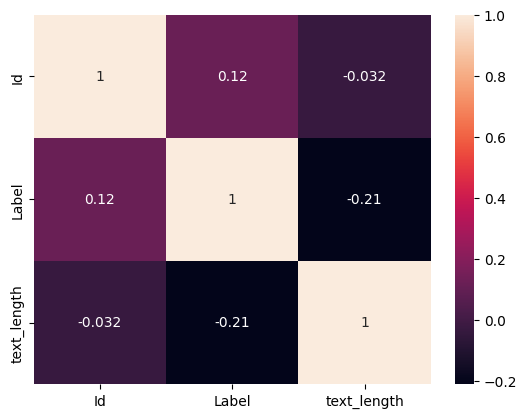

In [21]:
import seaborn as sns
ax = sns.heatmap(df.corr(),annot=True)

In [22]:
# We don't need the Id column. Let's drop it !
df.drop(columns=['Id'],inplace=True)
df.head()

,Review,Label,text_length
49,This course doesn't contain any new informatio...,1,159
71,I do not find very interesting this course. to...,1,186
79,A lot of speaking without any sense. Skip it a...,1,56
105,This course doesn't contain any new informatio...,1,159
173,It's not a course... this is a very short gene...,1,77


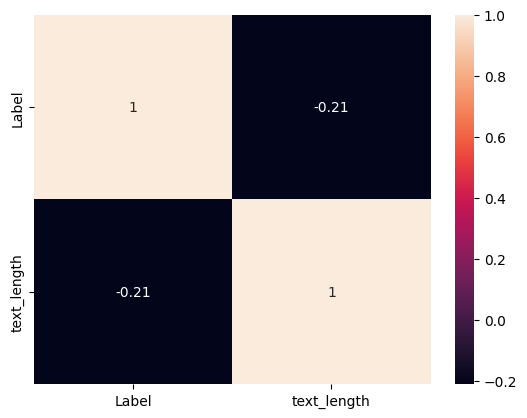

In [23]:
import seaborn as sns
ax = sns.heatmap(df.corr(),annot=True)

# DATA CLEANING

In [24]:
#remove hashtags
df['Review'].replace( { r"#(\w+)" : '' }, inplace= True, regex = True)
#Remove Mention
df['Review'].replace( { r"@(\w+)" : '' }, inplace= True, regex = True)
#Remove URL
df['Review'].astype(str).replace( { r"http\S+" : '' }, inplace= True, regex = True)

df['Review']=df['Review'].str.lower()

In [25]:
# Import stopwords with nltk.
from nltk.corpus import stopwords
stop = stopwords.words('english')

In [26]:
df['Review'] = df['Review'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))

# After Data Cleaning

In [27]:
df.head()

,Review,Label,text_length
49,course contain new information. teach excitedl...,1,159
71,find interesting course. many interviews. coul...,1,186
79,lot speaking without sense. skip cost,1,56
105,course contain new information. teach excitedl...,1,159
173,course... short general introduction 3d printing,1,77


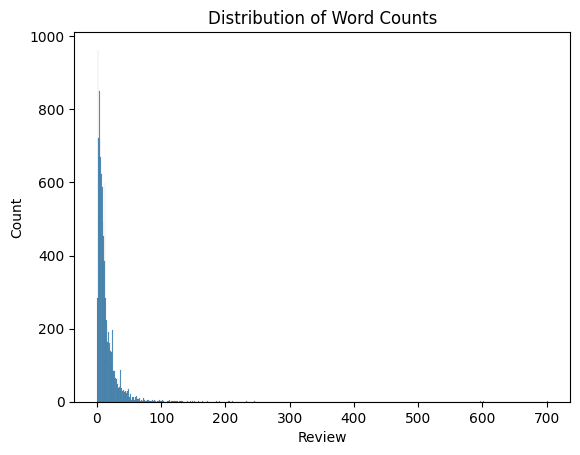

In [28]:
word_count = df['Review'].apply(lambda x: len(x.split()))
sns.histplot(word_count)
plt.title('Distribution of Word Counts')
plt.show()

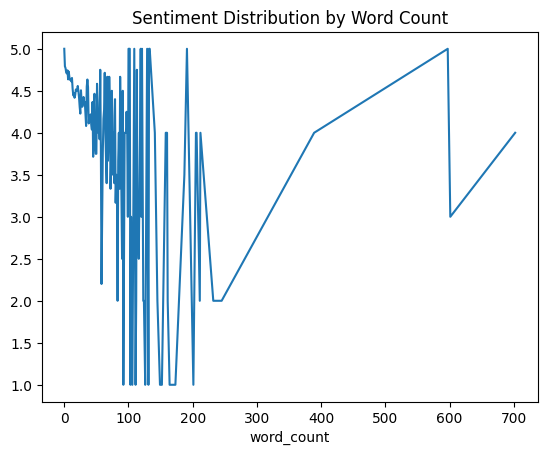

In [29]:
df['word_count'] = word_count
df.groupby('word_count')['Label'].mean().plot()
plt.title('Sentiment Distribution by Word Count')
plt.show()

# Label 1

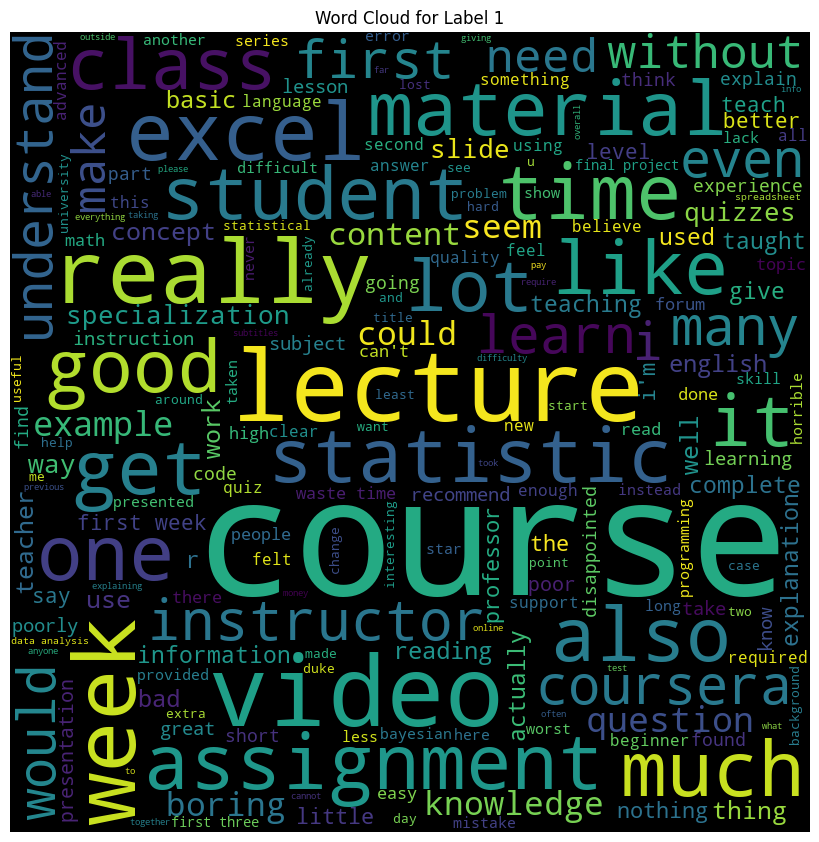

In [30]:
label1_texts = df[df['Label'] == 1]['Review']
label1_wordcloud = WordCloud(width=800, height=800, background_color='black', stopwords=set()).generate(' '.join(label1_texts))
plt.figure(figsize=(8, 8), facecolor=None)
plt.imshow(label1_wordcloud)
plt.axis('off')
plt.tight_layout(pad=0)
plt.title('Word Cloud for Label 1')
plt.show()

# Label 2

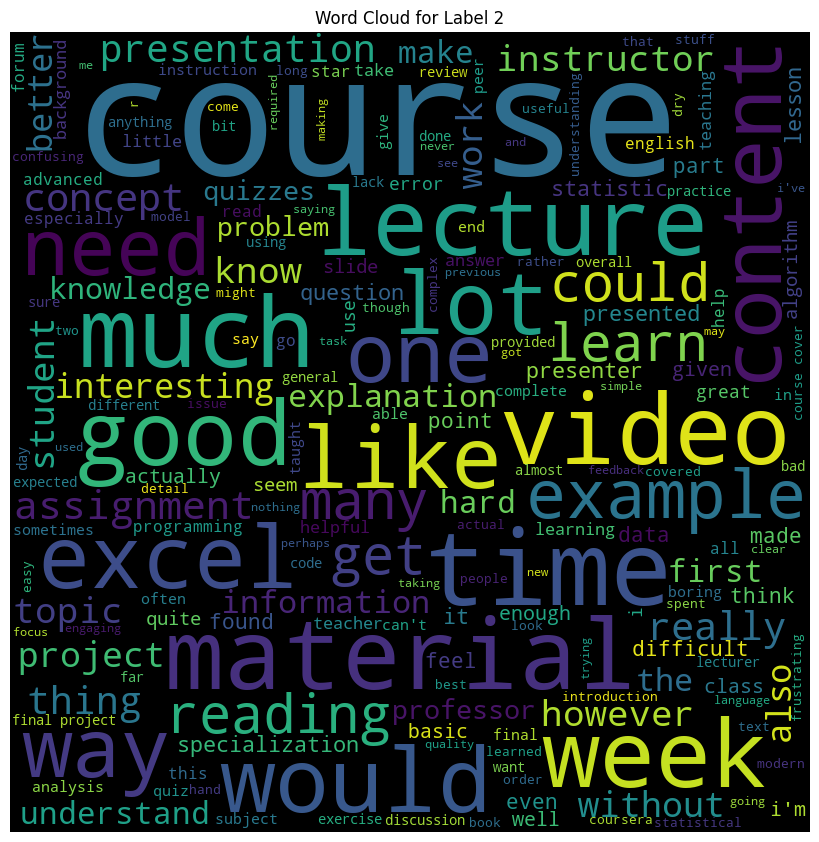

In [31]:
label2_texts = df[df['Label'] == 2]['Review']
label2_wordcloud = WordCloud(width=800, height=800, background_color='black', stopwords=set()).generate(' '.join(label2_texts))
plt.figure(figsize=(8, 8), facecolor=None)
plt.imshow(label2_wordcloud)
plt.axis('off')
plt.tight_layout(pad=0)
plt.title('Word Cloud for Label 2')
plt.show()


# Label 3

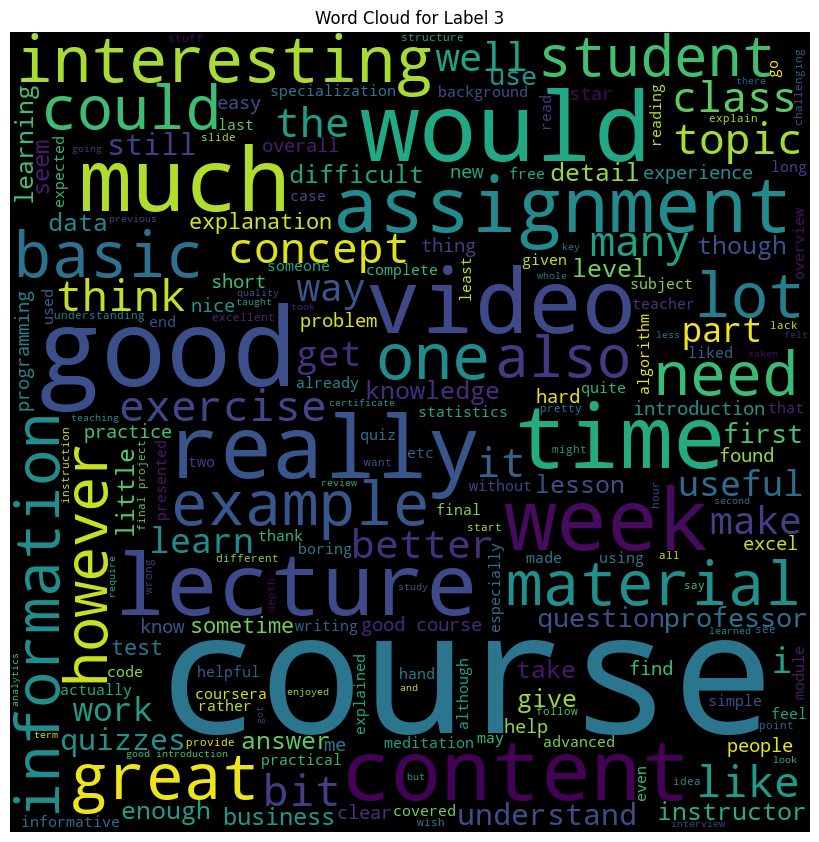

In [32]:
label3_texts = df[df['Label'] == 3]['Review']
label3_wordcloud = WordCloud(width=800, height=800, background_color='black', stopwords=set()).generate(' '.join(label3_texts))
plt.figure(figsize=(8, 8), facecolor=None)
plt.imshow(label3_wordcloud)
plt.axis('off')
plt.tight_layout(pad=0)
plt.title('Word Cloud for Label 3')
plt.show()


# Label 4

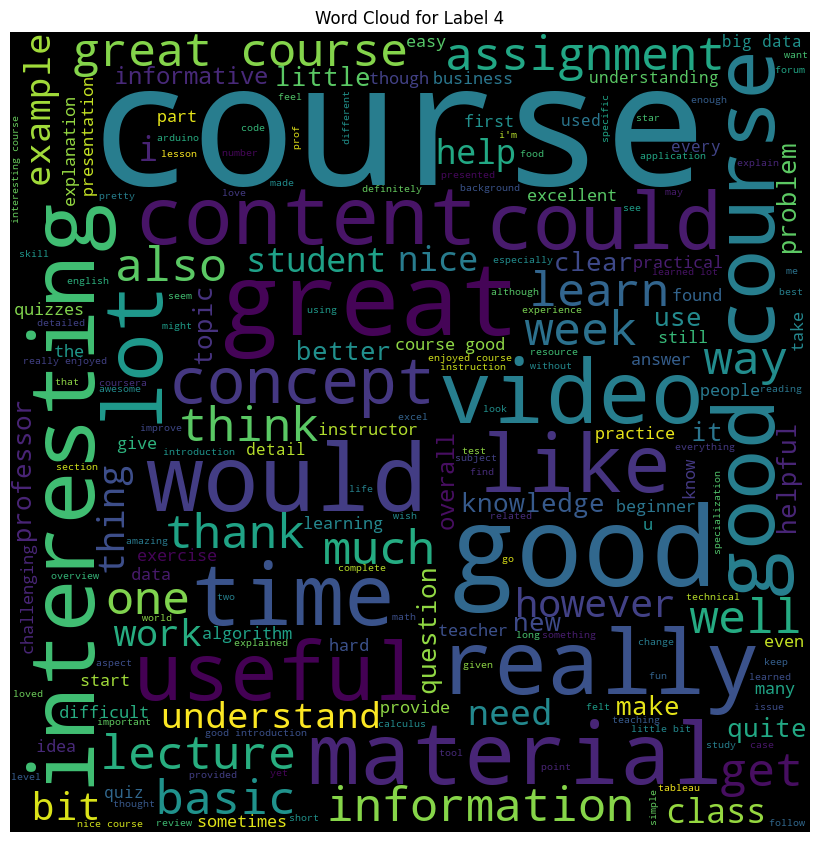

In [33]:
label4_texts = df[df['Label'] == 4]['Review']
label4_wordcloud = WordCloud(width=800, height=800, background_color='black', stopwords=set()).generate(' '.join(label4_texts))
plt.figure(figsize=(8, 8), facecolor=None)
plt.imshow(label4_wordcloud)
plt.axis('off')
plt.tight_layout(pad=0)
plt.title('Word Cloud for Label 4')
plt.show()


# Label 5

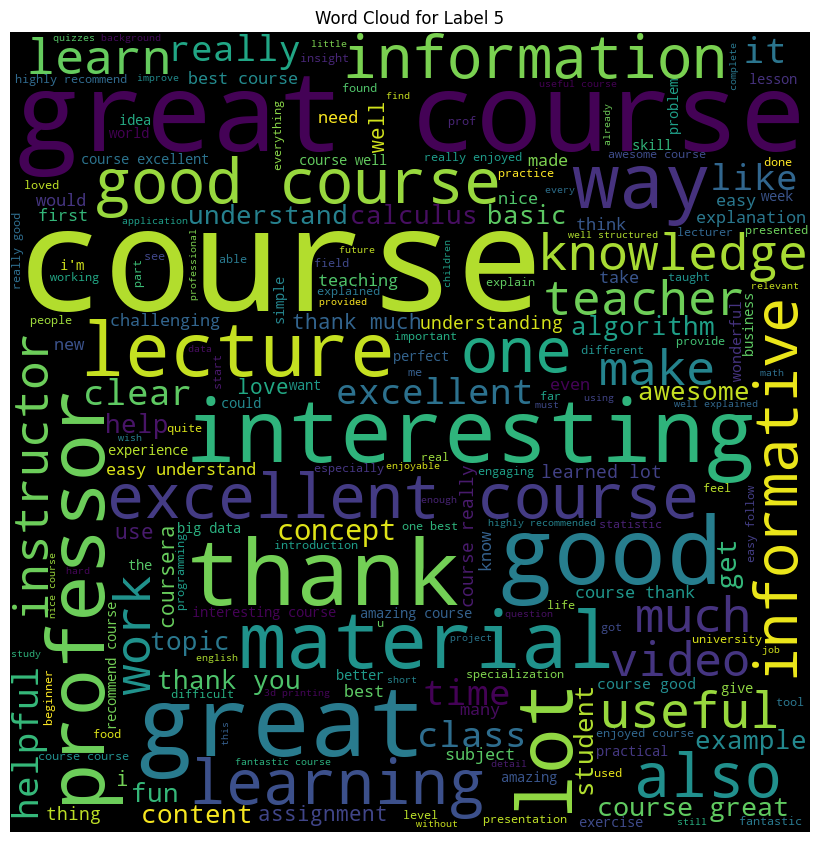

In [34]:
label5_texts = df[df['Label'] == 5]['Review']
label5_wordcloud = WordCloud(width=800, height=800, background_color='black', stopwords=set()).generate(' '.join(label5_texts))
plt.figure(figsize=(8, 8), facecolor=None)
plt.imshow(label5_wordcloud)
plt.axis('off')
plt.tight_layout(pad=0)
plt.title('Word Cloud for Label 5')
plt.show()


# Stemming

In [35]:
from nltk.corpus import stopwords

nltk.download('stopwords')
ps = PorterStemmer()
df['Review'] = df['Review'].apply(lambda x: ' '.join([ps.stem(word) for word in x.split() if word not in set(stopwords.words('english'))]))


[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Punctuation Removal 

In [36]:
import string
nlp = spacy.load('en_core_web_sm')
punctuations = string.punctuation
df['Review'] = df['Review'].apply(lambda x: ' '.join([token.text for token in nlp(x) if not token.is_punct]))


In [37]:
df.head()

,Review,Label,text_length,word_count
49,cours contain new information teach excitedli ...,1,159,14
71,find interest course mani interviews could wor...,1,186,14
79,lot speak without sense skip cost,1,56,6
105,cours contain new information teach excitedli ...,1,159,14
173,course short gener introduct 3d print,1,77,6


# Randomization

In [38]:
#randomization
df = df.sample(frac=1).reset_index(drop=True)
df.head()

,Review,Label,text_length,word_count
0,wonder experience great know aid epidemic role...,5,522,51
1,wish thank fantast cours introduc excit world ...,5,317,31
2,well presented wonder insight world ancient gr...,5,188,18
3,first three class certif excellent cours anyth...,1,878,80
4,good course quiz exercis difficult sometimes u...,3,102,7


# EDA for final Dataset

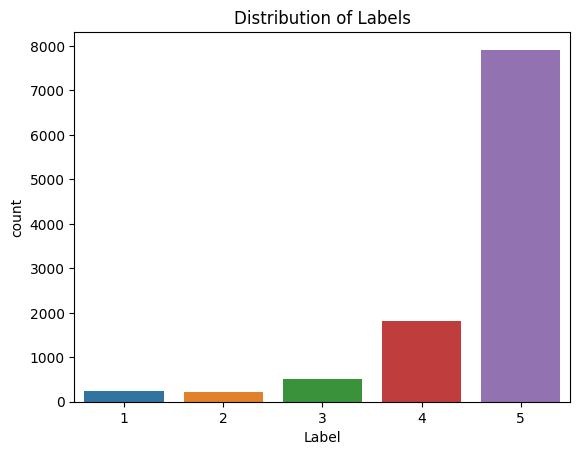

In [39]:
sns.countplot(x='Label',data=df)
plt.title('Distribution of Labels')
plt.show()

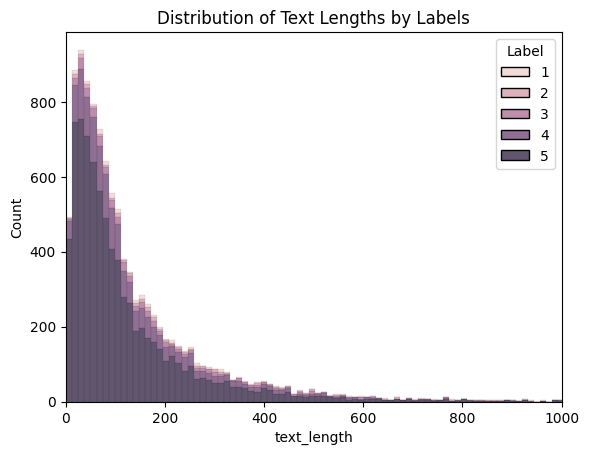

In [40]:
sns.histplot(x='text_length', data=df, hue='Label', multiple='stack')
plt.title('Distribution of Text Lengths by Labels')
plt.xlim(0, 1000)
plt.show()

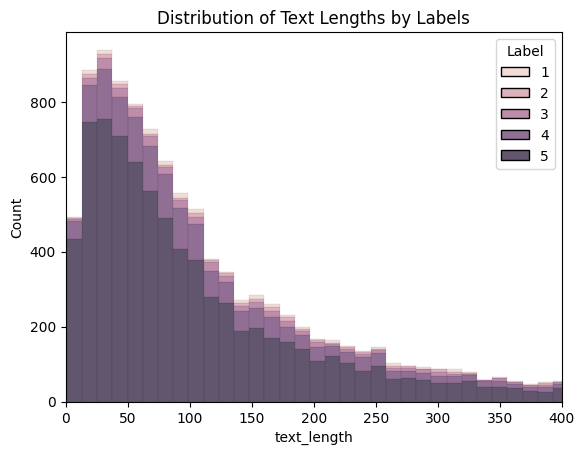

In [41]:
sns.histplot(x='text_length', data=df, hue='Label', multiple='stack')
plt.title('Distribution of Text Lengths by Labels')
plt.xlim(0, 400)
plt.show()

In [42]:
df.shape

(10700, 4)

In [43]:
df['Label'].value_counts()

5    7917
4    1805
3     507
1     246
2     225
Name: Label, dtype: int64

# Defining X and Y

In [44]:
y = df['Label']
x = df['Review']

# Vectorization using TFIDF

In [45]:
# Creating a word corpus for vectorization
corpus = []
for i in range(x.shape[0]):
    corpus.append(x.iloc[i])

In [46]:
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
import csv
import re 
import string
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

In [47]:
vectorizer1 = TfidfVectorizer(max_features=1000)
X1 = vectorizer1.fit_transform(x)
feature_names1 = vectorizer1.get_feature_names_out()
denselist1 = X1.todense().tolist()
train = pd.DataFrame(denselist1, columns=feature_names1)

In [48]:
# splitting the training and testing part from the data
X_train, X_test, y_train, y_test = train_test_split(train, y, test_size=0.2, random_state=0)


In [49]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((8560, 1000), (2140, 1000), (8560,), (2140,))

In [50]:
df.head()

,Review,Label,text_length,word_count
0,wonder experience great know aid epidemic role...,5,522,51
1,wish thank fantast cours introduc excit world ...,5,317,31
2,well presented wonder insight world ancient gr...,5,188,18
3,first three class certif excellent cours anyth...,1,878,80
4,good course quiz exercis difficult sometimes u...,3,102,7


In [51]:
df.head()

,Review,Label,text_length,word_count
0,wonder experience great know aid epidemic role...,5,522,51
1,wish thank fantast cours introduc excit world ...,5,317,31
2,well presented wonder insight world ancient gr...,5,188,18
3,first three class certif excellent cours anyth...,1,878,80
4,good course quiz exercis difficult sometimes u...,3,102,7


In [52]:
df1 = df.copy()

# LSTM Testing

In [53]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import matplotlib.pyplot as plt


In [54]:
X_train, y_train = np.array(X_train), np.array(y_train)

In [55]:
X_train.shape

(8560, 1000)

In [56]:
X_train.size

8560000

In [57]:
y_train

array([2, 5, 5, ..., 5, 5, 5])

In [58]:
y_train.shape

(8560,)

In [59]:
# Reshaping X_train for efficient modelling
X_train1 = np.reshape(X_train, (X_train.shape[0],X_train.shape[1],1))

In [60]:
X_test = np.array(X_test)

In [61]:
y_test = np.array(y_test)

In [62]:
# Reshaping X_test for efficient modelling
X_test1 = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))

In [63]:
from keras.utils import to_categorical

# Convert labels to one-hot encoded format
y_train_encoded = to_categorical(y_train, num_classes=6)
y_test_encoded = to_categorical(y_test, num_classes=6)

# Creating the LSTM model
model = Sequential()
model.add(LSTM(64, input_shape=(X_train1.shape[1], 1)))
model.add(Dense(6, activation='sigmoid'))

# Compiling the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Training the model
history = model.fit(X_train1, y_train_encoded, epochs=10, batch_size=32, validation_data=(X_test1, y_test_encoded))

Epoch 1/10
268/268 [==============================] - 103s 377ms/step - loss: 0.2646 - accuracy: 0.7360 - val_loss: 0.2363 - val_accuracy: 0.7477
Epoch 2/10
268/268 [==============================] - 100s 374ms/step - loss: 0.2398 - accuracy: 0.7380 - val_loss: 0.2354 - val_accuracy: 0.7477
Epoch 3/10
268/268 [==============================] - 101s 378ms/step - loss: 0.2399 - accuracy: 0.7380 - val_loss: 0.2349 - val_accuracy: 0.7477
Epoch 4/10
268/268 [==============================] - 100s 372ms/step - loss: 0.2400 - accuracy: 0.7380 - val_loss: 0.2342 - val_accuracy: 0.7477
Epoch 5/10
268/268 [==============================] - 100s 373ms/step - loss: 0.2399 - accuracy: 0.7380 - val_loss: 0.2344 - val_accuracy: 0.7477
Epoch 6/10
268/268 [==============================] - 99s 370ms/step - loss: 0.2398 - accuracy: 0.7380 - val_loss: 0.2348 - val_accuracy: 0.7477
Epoch 7/10
268/268 [==============================] - 100s 373ms/step - loss: 0.2397 - accuracy: 0.7380 - val_loss: 0.2341 - 

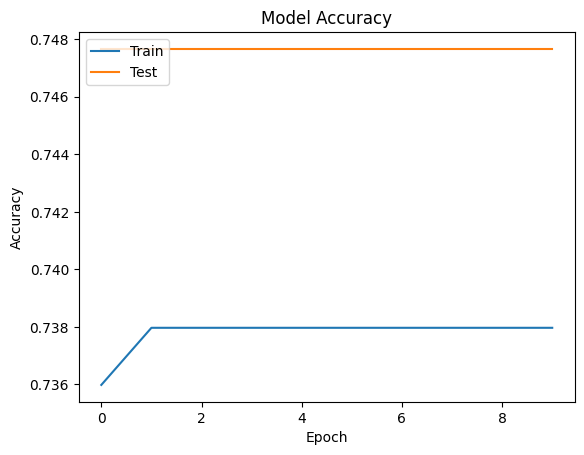

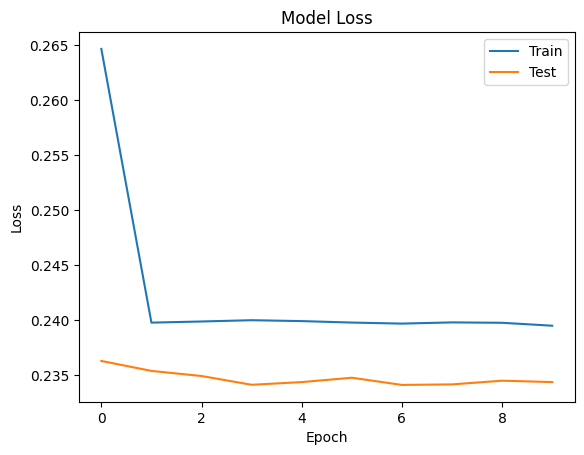

In [64]:
# Plotting accuracy and loss curves
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()

# TFIDF + Neural Networks

# RELU + RELU + TANH

Epoch 1/20
214/214 [==============================] - 1s 4ms/step - loss: 0.3086 - accuracy: 0.7342 - val_loss: 0.2735 - val_accuracy: 0.7360
Epoch 2/20
214/214 [==============================] - 1s 4ms/step - loss: 0.2403 - accuracy: 0.7421 - val_loss: 0.2617 - val_accuracy: 0.7401
Epoch 3/20
214/214 [==============================] - 1s 3ms/step - loss: 0.2082 - accuracy: 0.7703 - val_loss: 0.2521 - val_accuracy: 0.7465
Epoch 4/20
214/214 [==============================] - 1s 3ms/step - loss: 0.1659 - accuracy: 0.7919 - val_loss: 0.2517 - val_accuracy: 0.7430
Epoch 5/20
214/214 [==============================] - 1s 3ms/step - loss: 0.1502 - accuracy: 0.8160 - val_loss: 0.2989 - val_accuracy: 0.7401
Epoch 6/20
214/214 [==============================] - 1s 4ms/step - loss: 0.1370 - accuracy: 0.8436 - val_loss: 0.3595 - val_accuracy: 0.7348
Epoch 7/20
214/214 [==============================] - 1s 3ms/step - loss: 0.1246 - accuracy: 0.8662 - val_loss: 0.4168 - val_accuracy: 0.7354
Epoch 

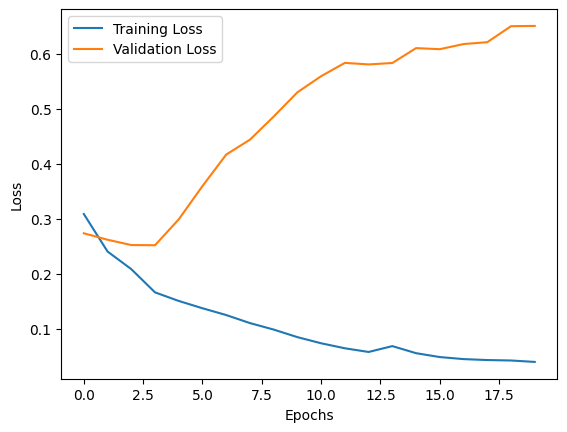

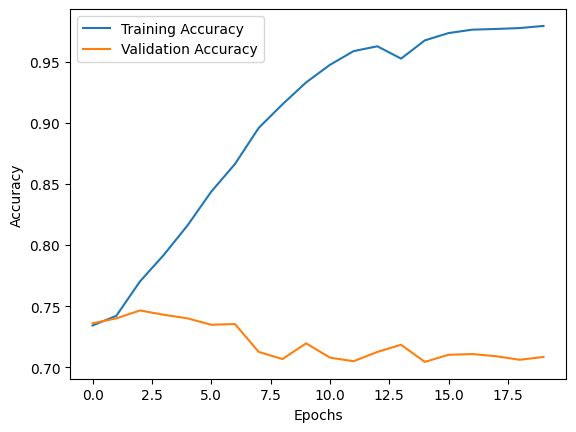

In [65]:
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers


input_dim = X_train.shape[1]


model = keras.Sequential()
model.add(layers.Dense(64, input_dim=input_dim, activation='relu'))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(6, activation='tanh'))


model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])


history=model.fit(X_train, y_train_encoded , epochs=20, batch_size=32, validation_split=0.2)

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


In [66]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 64)                64064     
                                                                 
 dense_2 (Dense)             (None, 32)                2080      
                                                                 
 dense_3 (Dense)             (None, 6)                 198       
                                                                 
Total params: 66,342
Trainable params: 66,342
Non-trainable params: 0
_________________________________________________________________


# RELU + RELU + RELU + TANH

Epoch 1/20
214/214 [==============================] - 2s 5ms/step - loss: 0.2840 - accuracy: 0.7339 - val_loss: 0.1763 - val_accuracy: 0.7360
Epoch 2/20
214/214 [==============================] - 1s 4ms/step - loss: 0.1745 - accuracy: 0.7385 - val_loss: 0.1761 - val_accuracy: 0.7360
Epoch 3/20
214/214 [==============================] - 1s 4ms/step - loss: 0.1744 - accuracy: 0.7385 - val_loss: 0.1760 - val_accuracy: 0.7360
Epoch 4/20
214/214 [==============================] - 1s 5ms/step - loss: 0.1744 - accuracy: 0.7385 - val_loss: 0.1760 - val_accuracy: 0.7360
Epoch 5/20
214/214 [==============================] - 1s 4ms/step - loss: 0.1744 - accuracy: 0.7385 - val_loss: 0.1760 - val_accuracy: 0.7360
Epoch 6/20
214/214 [==============================] - 1s 4ms/step - loss: 0.1744 - accuracy: 0.7385 - val_loss: 0.1760 - val_accuracy: 0.7360
Epoch 7/20
214/214 [==============================] - 1s 4ms/step - loss: 0.1744 - accuracy: 0.7385 - val_loss: 0.1760 - val_accuracy: 0.7360
Epoch 

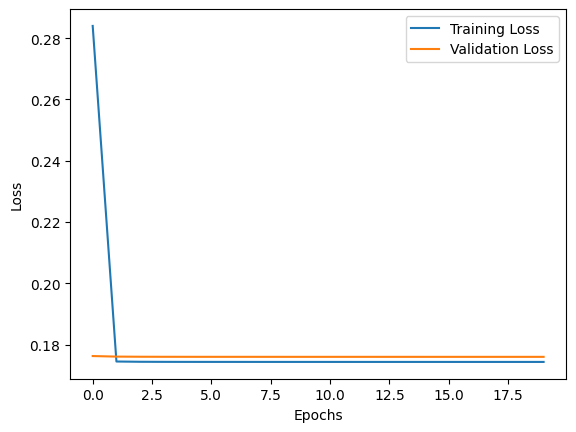

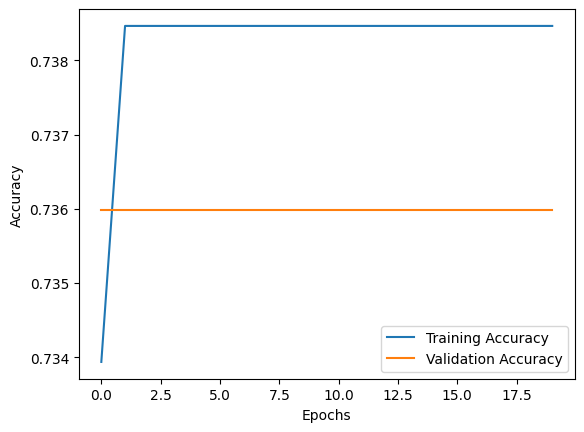

In [67]:
input_dim = X_train.shape[1]

model = keras.Sequential()
model.add(layers.Dense(128, input_dim=input_dim, activation='relu'))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(6, activation='tanh'))


model.compile(loss='hinge', optimizer='adam', metrics=['accuracy'])


history=model.fit(X_train, y_train_encoded, epochs=20, batch_size=32, validation_split=0.2)

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# RELU + RELU + RELU + RELU + TANH

Epoch 1/20
214/214 [==============================] - 2s 4ms/step - loss: 0.3220 - accuracy: 0.7376 - val_loss: 0.2402 - val_accuracy: 0.7453
Epoch 2/20
214/214 [==============================] - 1s 3ms/step - loss: 0.2213 - accuracy: 0.7702 - val_loss: 0.2424 - val_accuracy: 0.7482
Epoch 3/20
214/214 [==============================] - 1s 3ms/step - loss: 0.2017 - accuracy: 0.7959 - val_loss: 0.2460 - val_accuracy: 0.7407
Epoch 4/20
214/214 [==============================] - 1s 3ms/step - loss: 0.1770 - accuracy: 0.8208 - val_loss: 0.2662 - val_accuracy: 0.7214
Epoch 5/20
214/214 [==============================] - 1s 3ms/step - loss: 0.1460 - accuracy: 0.8551 - val_loss: 0.2796 - val_accuracy: 0.7196
Epoch 6/20
214/214 [==============================] - 1s 3ms/step - loss: 0.1226 - accuracy: 0.8807 - val_loss: 0.2941 - val_accuracy: 0.7091
Epoch 7/20
214/214 [==============================] - 1s 4ms/step - loss: 0.1051 - accuracy: 0.9019 - val_loss: 0.3148 - val_accuracy: 0.6992
Epoch 

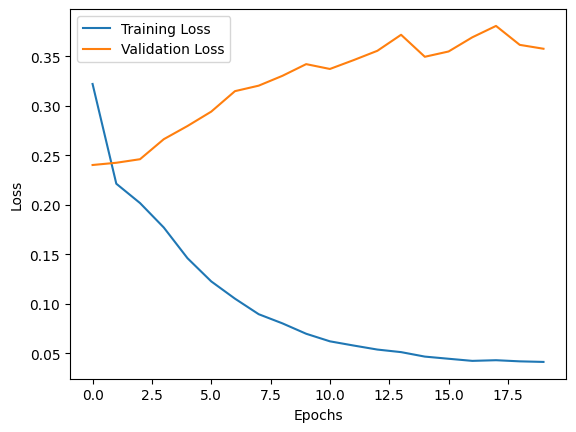

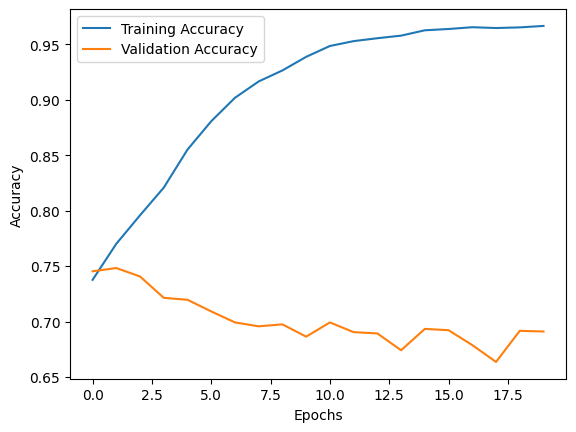

In [68]:
input_dim = X_train.shape[1]

model = keras.Sequential()
model.add(layers.Dense(32, input_dim=input_dim, activation='relu'))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(6, activation='tanh'))

model.compile(loss='squared_hinge', optimizer='adam', metrics=['accuracy'])

history=model.fit(X_train, y_train_encoded, epochs=20, batch_size=32, validation_split=0.2)

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# RELU + RELU + RELU + RELU + TANH

Epoch 1/20
214/214 [==============================] - 2s 6ms/step - loss: 0.3984 - accuracy: 0.7287 - val_loss: 0.3382 - val_accuracy: 0.7360
Epoch 2/20
214/214 [==============================] - 1s 5ms/step - loss: 0.2449 - accuracy: 0.7557 - val_loss: 0.2197 - val_accuracy: 0.7401
Epoch 3/20
214/214 [==============================] - 1s 4ms/step - loss: 0.1825 - accuracy: 0.7810 - val_loss: 0.2272 - val_accuracy: 0.7430
Epoch 4/20
214/214 [==============================] - 1s 4ms/step - loss: 0.1575 - accuracy: 0.8205 - val_loss: 0.2898 - val_accuracy: 0.7214
Epoch 5/20
214/214 [==============================] - 1s 5ms/step - loss: 0.1298 - accuracy: 0.8715 - val_loss: 0.3984 - val_accuracy: 0.7237
Epoch 6/20
214/214 [==============================] - 1s 5ms/step - loss: 0.1042 - accuracy: 0.9061 - val_loss: 0.4480 - val_accuracy: 0.7109
Epoch 7/20
214/214 [==============================] - 1s 5ms/step - loss: 0.0985 - accuracy: 0.9241 - val_loss: 0.5377 - val_accuracy: 0.7015
Epoch 

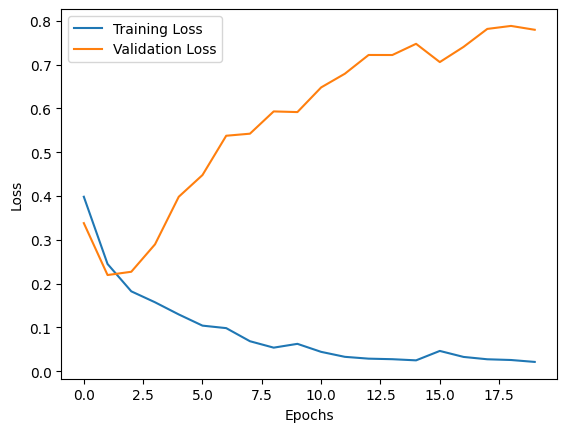

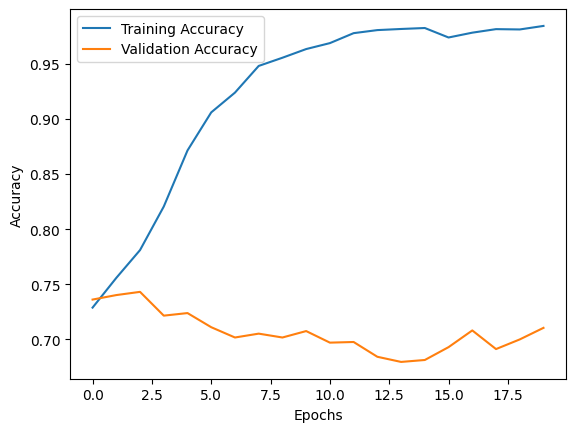

In [69]:
input_dim = X_train.shape[1]

model = keras.Sequential()
model.add(layers.Dense(128, input_dim=input_dim, activation='relu'))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dense(6, activation='tanh'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

history = model.fit(X_train, y_train_encoded, epochs=20, batch_size=32, validation_split=0.2)

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# BOW + Neural Networks

In [70]:
df1.head()

,Review,Label,text_length,word_count
0,wonder experience great know aid epidemic role...,5,522,51
1,wish thank fantast cours introduc excit world ...,5,317,31
2,well presented wonder insight world ancient gr...,5,188,18
3,first three class certif excellent cours anyth...,1,878,80
4,good course quiz exercis difficult sometimes u...,3,102,7


In [71]:
x1 = df1['Review']
y1 = df1['Label']

In [72]:
# Creating a word corpus for vectorization
corpus = []
for i in range(x1.shape[0]):
    corpus.append(x1.iloc[i])

In [73]:
vectorizer_train = CountVectorizer(max_features=1000)
vocabulary_train = vectorizer_train.fit_transform(corpus)
bow = pd.DataFrame(vocabulary_train.toarray(), columns = vectorizer_train.get_feature_names_out())

In [74]:
bow['labelxyz']=df1.Label

In [75]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

# Training & Testing

In [76]:
bow_zero = bow[bow.labelxyz == 0]
bow_one = bow[bow.labelxyz == 1]
bow_two = bow[bow.labelxyz == 2]
bow_three = bow[bow.labelxyz == 3]
bow_four = bow[bow.labelxyz == 4]
bow_five = bow[bow.labelxyz == 5]

In [77]:
X_train_zero = bow_zero.sample(frac=0.8, random_state=0)
X_test_zero = bow_zero.drop(X_train_zero.index)
X_train_one = bow_one.sample(frac=0.8, random_state=0)
X_test_one = bow_one.drop(X_train_one.index)
X_train_two = bow_two.sample(frac=0.8, random_state=0)
X_test_two = bow_two.drop(X_train_two.index)
X_train_three = bow_three.sample(frac=0.8, random_state=0)
X_test_three = bow_three.drop(X_train_three.index)
X_train_four = bow_four.sample(frac=0.8, random_state=0)
X_test_four = bow_four.drop(X_train_four.index)
X_train_five = bow_five.sample(frac=0.8, random_state=0)
X_test_five = bow_five.drop(X_train_five.index)

In [78]:
X_train_df = pd.concat([X_train_zero, X_train_one, X_train_two, X_train_three, X_train_four, X_train_five], axis = 0)
bow_train = X_train_df.drop(['labelxyz'], axis = 1)
y_train1 = list(X_train_df.labelxyz)
X_test_df = pd.concat([X_test_zero, X_test_one, X_test_two, X_test_three, X_test_four, X_test_five], axis = 0)
bow_test = X_test_df.drop(['labelxyz'], axis = 1)
y_test1 = list(X_test_df.labelxyz)

In [79]:
# Convert labels to one-hot encoded format
y_train_encoded = to_categorical(y_train1, num_classes=6)
y_test_encoded = to_categorical(y_test1, num_classes=6)

In [80]:
bow_train, y_train1 = np.array(bow_train), np.array(y_train1)

In [81]:
bow_test, y_test1 = np.array(bow_test), np.array(y_test1)

# RELU + SIGMOID

Epoch 1/10
214/214 [==============================] - 1s 4ms/step - loss: 0.3791 - accuracy: 0.6564 - val_loss: 0.1291 - val_accuracy: 0.9889
Epoch 2/10
214/214 [==============================] - 1s 3ms/step - loss: 0.2305 - accuracy: 0.7079 - val_loss: 0.1037 - val_accuracy: 0.9679
Epoch 3/10
214/214 [==============================] - 1s 3ms/step - loss: 0.2032 - accuracy: 0.7405 - val_loss: 0.0964 - val_accuracy: 0.9527
Epoch 4/10
214/214 [==============================] - 1s 4ms/step - loss: 0.1884 - accuracy: 0.7645 - val_loss: 0.0968 - val_accuracy: 0.9457
Epoch 5/10
214/214 [==============================] - 1s 4ms/step - loss: 0.1765 - accuracy: 0.7821 - val_loss: 0.0906 - val_accuracy: 0.9440
Epoch 6/10
214/214 [==============================] - 1s 4ms/step - loss: 0.1661 - accuracy: 0.7975 - val_loss: 0.1060 - val_accuracy: 0.9165
Epoch 7/10
214/214 [==============================] - 1s 4ms/step - loss: 0.1565 - accuracy: 0.8154 - val_loss: 0.0763 - val_accuracy: 0.9539
Epoch 

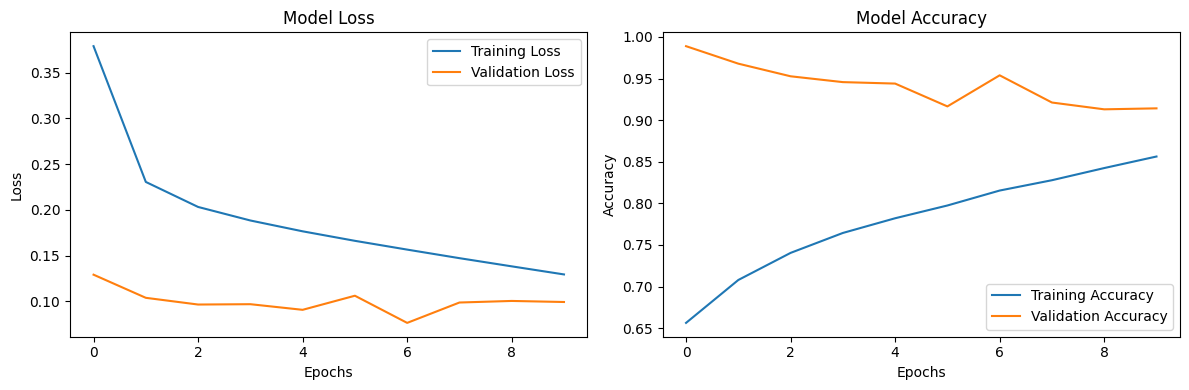

In [82]:
from sklearn.model_selection import train_test_split
import tensorflow as tf
from sklearn.feature_extraction.text import CountVectorizer

model = tf.keras.Sequential([
    tf.keras.layers.Dense(64, activation='relu', input_shape=(bow_train.shape[1],)),
    tf.keras.layers.Dense(6, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

history = model.fit(bow_train, y_train_encoded, epochs=10, batch_size=32, validation_split=0.2)

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

# 

# RELU + RELU + SIGMOID

Epoch 1/10
214/214 [==============================] - 2s 5ms/step - loss: 0.3097 - accuracy: 0.6720 - val_loss: 0.0872 - val_accuracy: 0.9749
Epoch 2/10
214/214 [==============================] - 1s 4ms/step - loss: 0.2040 - accuracy: 0.7377 - val_loss: 0.0827 - val_accuracy: 0.9562
Epoch 3/10
214/214 [==============================] - 1s 4ms/step - loss: 0.1784 - accuracy: 0.7802 - val_loss: 0.0844 - val_accuracy: 0.9381
Epoch 4/10
214/214 [==============================] - 1s 4ms/step - loss: 0.1515 - accuracy: 0.8198 - val_loss: 0.0948 - val_accuracy: 0.9212
Epoch 5/10
214/214 [==============================] - 1s 4ms/step - loss: 0.1229 - accuracy: 0.8661 - val_loss: 0.0885 - val_accuracy: 0.9189
Epoch 6/10
214/214 [==============================] - 1s 5ms/step - loss: 0.0962 - accuracy: 0.9019 - val_loss: 0.1112 - val_accuracy: 0.8891
Epoch 7/10
214/214 [==============================] - 1s 4ms/step - loss: 0.0750 - accuracy: 0.9260 - val_loss: 0.1226 - val_accuracy: 0.8821
Epoch 

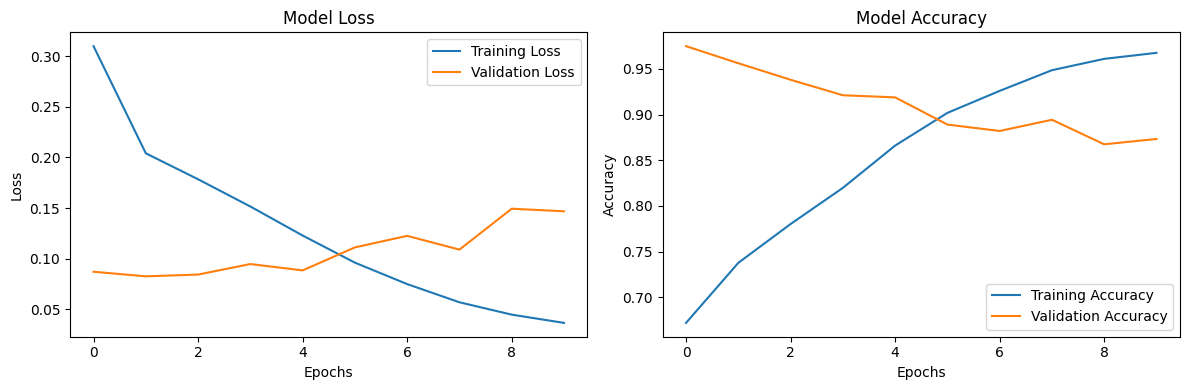

In [83]:
from sklearn.model_selection import train_test_split
import tensorflow as tf
from sklearn.feature_extraction.text import CountVectorizer

model = tf.keras.Sequential([
    tf.keras.layers.Dense(128, activation='relu', input_shape=(bow_train.shape[1],)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(6, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

history = model.fit(bow_train, y_train_encoded, epochs=10, batch_size=32, validation_split=0.2)

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

Epoch 1/10
214/214 [==============================] - 2s 6ms/step - loss: 0.4425 - accuracy: 0.3499 - val_loss: 0.0953 - val_accuracy: 0.9802
Epoch 2/10
214/214 [==============================] - 1s 5ms/step - loss: 0.2197 - accuracy: 0.7161 - val_loss: 0.1172 - val_accuracy: 0.9019
Epoch 3/10
214/214 [==============================] - 1s 5ms/step - loss: 0.1915 - accuracy: 0.7484 - val_loss: 0.0838 - val_accuracy: 0.9358
Epoch 4/10
214/214 [==============================] - 1s 4ms/step - loss: 0.1643 - accuracy: 0.7929 - val_loss: 0.0950 - val_accuracy: 0.9048
Epoch 5/10
214/214 [==============================] - 1s 5ms/step - loss: 0.1280 - accuracy: 0.8483 - val_loss: 0.1344 - val_accuracy: 0.8587
Epoch 6/10
214/214 [==============================] - 1s 5ms/step - loss: 0.0916 - accuracy: 0.9035 - val_loss: 0.1560 - val_accuracy: 0.8342
Epoch 7/10
214/214 [==============================] - 1s 5ms/step - loss: 0.0634 - accuracy: 0.9388 - val_loss: 0.1414 - val_accuracy: 0.8710
Epoch 

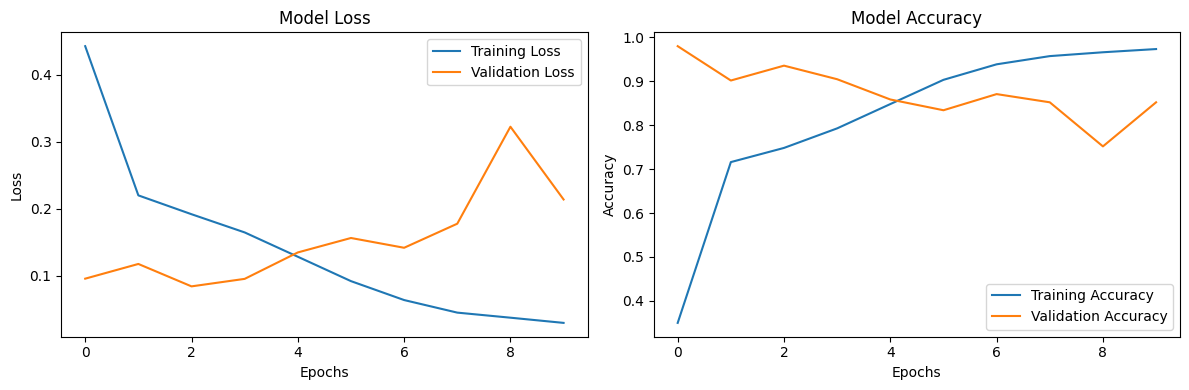

In [84]:
from sklearn.model_selection import train_test_split
import tensorflow as tf
from sklearn.feature_extraction.text import CountVectorizer

model = tf.keras.Sequential([
    tf.keras.layers.Dense(128, activation='relu', input_shape=(bow_train.shape[1],)),
    tf.keras.layers.Dense(64, activation='relu'),
     tf.keras.layers.Dense(32, activation='relu'),
     tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dense(6, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

history = model.fit(bow_train, y_train_encoded, epochs=10, batch_size=32, validation_split=0.2)

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

# BOW + LSTM

In [85]:
from keras.utils import to_categorical

# Convert labels to one-hot encoded format
y_train_encoded = to_categorical(y_train1, num_classes=6)
y_test_encoded = to_categorical(y_test1, num_classes=6)
# Creating the LSTM model
model = Sequential()
model.add(LSTM(64, input_shape=(bow_train.shape[1], 1)))
model.add(Dense(6, activation='sigmoid'))

# Compiling the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Training the model
history = model.fit(bow_train, y_train_encoded, epochs=10, batch_size=32, validation_data=(bow_test, y_test_encoded))

Epoch 1/10
268/268 [==============================] - 105s 385ms/step - loss: 0.2669 - accuracy: 0.7365 - val_loss: 0.2389 - val_accuracy: 0.7401
Epoch 2/10
268/268 [==============================] - 101s 376ms/step - loss: 0.2391 - accuracy: 0.7399 - val_loss: 0.2385 - val_accuracy: 0.7401
Epoch 3/10
268/268 [==============================] - 103s 383ms/step - loss: 0.2389 - accuracy: 0.7399 - val_loss: 0.2383 - val_accuracy: 0.7401
Epoch 4/10
268/268 [==============================] - 103s 383ms/step - loss: 0.2392 - accuracy: 0.7399 - val_loss: 0.2386 - val_accuracy: 0.7401
Epoch 5/10
268/268 [==============================] - 104s 390ms/step - loss: 0.2390 - accuracy: 0.7399 - val_loss: 0.2381 - val_accuracy: 0.7401
Epoch 6/10
268/268 [==============================] - 102s 382ms/step - loss: 0.2390 - accuracy: 0.7399 - val_loss: 0.2386 - val_accuracy: 0.7401
Epoch 7/10
268/268 [==============================] - 105s 390ms/step - loss: 0.2386 - accuracy: 0.7399 - val_loss: 0.2385 -

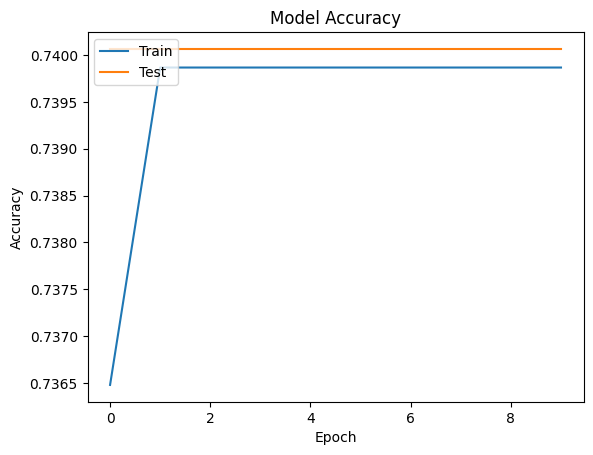

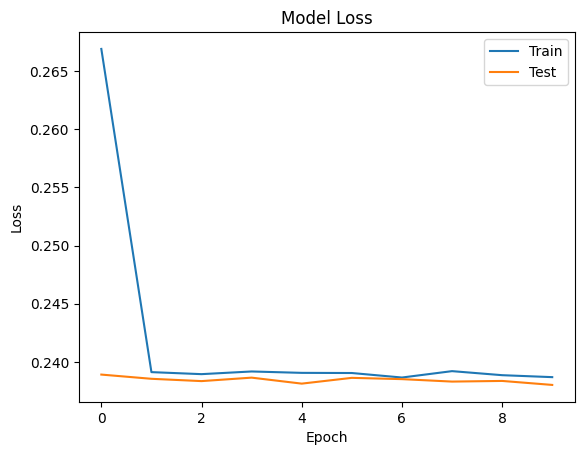

In [86]:
# Plotting accuracy and loss curves
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()